In [19]:
from skimage import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
# from Models import U_net3D
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
import sklearn
from skimage import feature



In [ ]:
class Evaluator:

    def __init__(self, test_folder, model):
        self.test_folder = test_folder
        self.model = model

eval = Evaluator(folder, model)
eval.compute_cell_numbers()
eval.compute_misclassified_number()
eval.compute_distances()


In [13]:
from skimage import filters, segmentation, measure, morphology
import tqdm

class CellCounter:

    def __init__(self, pdf:torch.tensor, threshold = 0.95) -> None:
        self.threshold = threshold
        self.Macrophage_pdf = pdf[0]
        self.T_Cell_pdf     = pdf[1]
        self.Background_pdf = pdf[2]

        self.

    def label_image(self, pdf):
        mask = pdf > self.threshold
        cleared = segmentation.clear_border(mask)
        label_image = measure.label(cleared)
        return label_image

    def count_cells_max(self):
        cell_pdf = 1 - self.Background_pdf
        label_image = self.label_image(cell_pdf)
        Num_of_cell = label_image.max()
        print(f'{Num_of_cell = }')
        cell_coordinates = feature.peak_local_max(cell_pdf, threshold_abs=self.threshold)
        # Per class
        dicto = {
            'name':'Macrophage',
            'pdf':self.Macrophage_pdf,
            ''        
            }
        classes = ['Macrophage', 'T_Cell']
        N_Macrophages = 0
        N_T_Cells = 0
        names = []
        for i, (y,x,z) in enumerate(cell_coordinates):
            p_m = self.Macrophage_pdf[y, x, z]
            p_t = self.T_Cell_pdf[y, x, z]

            if p_m > p_t: 
                N_Macrophages += 1
                names.append('Macrophage')
            else: N_T_Cells += 1

        print(f'{N_Macrophages = } {N_T_Cells = }')
        return cell_coordinates
            

            

pdfs = []
for i in range(3):
    a = np.load(f'C:/Users/Sergei/Documents/Test_output/U_net3D_epoch_250-class_{i}.npy')
    pdfs.append(a)

pdf = np.stack(pdfs)
print(pdf.shape)
CC = CellCounter(pdf)
coordinates = CC.count_cells_max()

(3, 500, 500, 100)
Num_of_cell = 636
N_Macrophages = 315 N_T_Cells = 321


In [18]:
df = pd.DataFrame(coordinates, columns = ['axis-0', 'axis-1', 'axis-2'])
df['name'] = ['M' for i in range(636)]
df

,axis-0,axis-1,axis-2,name
0,480,95,79,M
1,397,187,17,M
2,316,466,54,M
3,220,80,65,M
4,11,194,60,M
...,...,...,...,...
631,367,463,13,M
632,456,177,63,M
633,467,345,66,M
634,316,475,29,M


In [10]:
coordinates = feature.peak_local_max(1-pdfs[2],threshold_abs=0.95, min_distance=1)
print(len(coordinates))

636


T_Cell        321
Macrophage    315
Name: class, dtype: int64


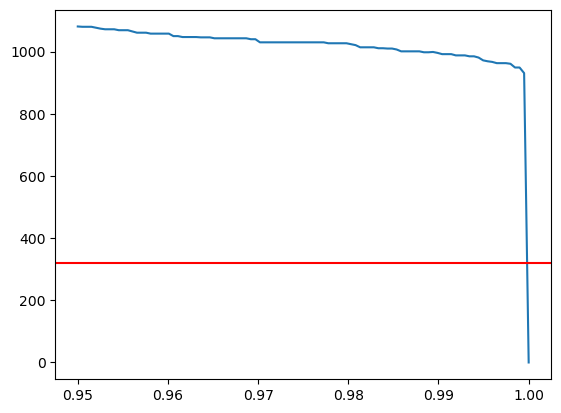

In [26]:
threshold = 0.99
i = 1
pdf = np.load(f'C:/Users/Sergei/Documents/Test_output/U_net3D_epoch_250-class_{i}.npy')
# plt.hist(pdf.flatten(), bins=1000)
# plt.axvline(threshold, c='r')
# plt.yscale('log')
# plt.show()
from tqdm import tqdm
cell_number = np.zeros([100])
thres = np.linspace(0.95,1.0,100)
pbar = tqdm(total=100)
for i, t in enumerate(thres):
    pbar.update(1)
    CC = CellCounter(threshold=t)
    cell_number[i] = CC.count_cells(pdf)

pbar.close()
df = pd.read_csv('C:/Users/Sergei/Documents/Test_output/stack_0.csv', index_col=0)
N = df['class'].value_counts()
print(N)

plt.plot(thres, cell_number)
plt.axhline(321, c='r')



In [17]:
df = pd.read_csv('data/raw/stack_0.csv', index_col=0)
N = df['class'].value_counts()
N

T_Cell        321
Macrophage    315
Name: class, dtype: int64